<a href="https://colab.research.google.com/github/Fadiabdf/bird_species_classification/blob/main/birds_classifiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification d'Espèces d'Oiseaux par Deep Learning avec Diffusion de Chants**

Ce projet combine classification visuelle d'espèces d'oiseaux et diffusion audio pour créer une expérience d'identification enrichie. Nous utilisons un réseau de neurones convolutif (CNN) avec transfer learning pour classer les oiseaux à partir d'images, puis nous diffusons leur chant caractéristique lorsque disponible.

Notre approche s'articule en deux phases :
1.   Classification d'images via un modèle Deep Learning (ResNet18)
2.   Recherche et diffusion du chant correspondant à l'espèce identifiée



* Le dataset principal provient de [Kaggle (200 espèces d'oiseaux) ](https://www.kaggle.com/datasets/kedarsai/bird-species-classification-220-categories), tandis que les chants d'oiseaux sont extraits de bases de données spécialisées comme Xeno-Canto

Commençons par préparer l'environnement de travail en :
- Installant les dépendances nécessaires
- Configurant le matériel (GPU)
- Téléchargeant le dataset depuis Kaggle

In [ ]:
!pip install  kagglehub
!pip install flask_compress
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.9 MB/s eta 0:00:00


In [ ]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
from collections import defaultdict
import random
from tqdm import tqdm
import time


import warnings
warnings.filterwarnings('ignore')

# Biblio for the evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Configuration
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [ ]:
# Vérification GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device utilisé: cuda
GPU: Tesla T4
Mémoire GPU disponible: 15.8 GB


**Téléchargement et Préparation du Dataset**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kedarsai/bird-species-classification-220-categories")

print("Path to dataset files:", path)

100%|██████████| 1.06G/1.06G [00:15<00:00, 73.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kedarsai/bird-species-classification-220-categories/versions/1


**Analyse des données**

Ici on analyse la structure et la distribution du dataset étudié en fournissant des statistiques détaillées sur :

* La répartition des images entre les dossiers Train/Test d'après le dataset
* Le nombre d'images par espèce
* Les similarités/différences entre les ensembles d'entraînement et de test

In [ ]:
from pathlib import Path
# Initialisation des Chemins
path = Path('/root/.cache/kagglehub/datasets/kedarsai/bird-species-classification-220-categories/versions/1')
train_path = path / 'Train'
test_path = path / 'Test'

def analyze_dataset_structure(data_path):
    """
    Analyse la structure et la distribution du dataset
    """
    species_info = {}
    total_images = 0

    # Vérifier si le chemin existe
    if not path.exists():
        print(f"Attention: Le dossier {data_path} n'existe pas!")
        return species_info, total_images

    # Parcours de tous les dossiers d'espèces
    for species_folder in os.listdir(data_path):
        species_path = data_path / species_folder
        if species_path.is_dir():
            # Comptage des images par espèce
            image_files = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                image_files.extend(species_path.glob(ext))
            num_images = len(image_files)
            species_info[species_folder] = {
                'count': num_images,
                'path': species_path,
                'sample_files': image_files[:3]  # Échantillon de fichiers
            }
            total_images += num_images
    return species_info, total_images

def display_statistics(species_data, total_images, dataset_name):
    """
    Affiche les statistiques pour un dataset donné
    """
    print(f"\n=== ANALYSE DU DATASET {dataset_name.upper()} ===")
    print(f"Nombre d'espèces d'oiseaux: {len(species_data)}")
    print(f"Nombre total d'images: {total_images}")

    if len(species_data) > 0:
        print(f"Moyenne d'images par espèce: {total_images/len(species_data):.1f}")
        counts = [info['count'] for info in species_data.values()]
        print(f"Min images par espèce: {min(counts)}")
        print(f"Max images par espèce: {max(counts)}")
        print(f"Médiane: {np.median(counts):.1f}")
    else:
        print("Aucune espèce trouvée dans ce dataset!")

# Analyse des deux datasets
print("Analyse en cours...")

# Dataset d'entraînement
train_species_data, train_total_images = analyze_dataset_structure(train_path)
display_statistics(train_species_data, train_total_images, "TRAIN")

# Dataset de test
test_species_data, test_total_images = analyze_dataset_structure(test_path)
display_statistics(test_species_data, test_total_images, "TEST")

# Statistiques globales
print(f"\n=== STATISTIQUES GLOBALES ===")
all_species = set(train_species_data.keys()) | set(test_species_data.keys())
total_species = len(all_species)
global_total_images = train_total_images + test_total_images

print(f"Nombre total d'espèces (union): {total_species}")
print(f"Nombre total d'images (train + test): {global_total_images}")

if global_total_images > 0:
    print(f"Moyenne globale d'images par espèce: {global_total_images/total_species:.1f}")

# Comparaison entre train et test
print(f"\n=== COMPARAISON TRAIN/TEST ===")
print(f"Ratio train/test: {train_total_images}/{test_total_images} = {train_total_images/test_total_images:.2f}" if test_total_images > 0 else "Pas de données de test")

# Espèces communes et différences
common_species = set(train_species_data.keys()) & set(test_species_data.keys())
train_only = set(train_species_data.keys()) - set(test_species_data.keys())
test_only = set(test_species_data.keys()) - set(train_species_data.keys())

print(f"Espèces communes aux deux datasets: {len(common_species)}")
print(f"Espèces uniquement dans train: {len(train_only)}")
print(f"Espèces uniquement dans test: {len(test_only)}")

# Affichage détaillé pour quelques espèces (optionnel)
print(f"\n=== ÉCHANTILLON D'ESPÈCES ===")
for i, (species, info) in enumerate(list(train_species_data.items())[:5]):
    test_count = test_species_data.get(species, {}).get('count', 0)
    print(f"{species}: Train={info['count']}, Test={test_count}")
    if i >= 4:  # Limiter à 5 espèces pour l'affichage
        break

Analyse en cours...

=== ANALYSE DU DATASET TRAIN ===
Nombre d'espèces d'oiseaux: 200
Nombre total d'images: 9414
Moyenne d'images par espèce: 47.1
Min images par espèce: 32
Max images par espèce: 48
Médiane: 48.0

=== ANALYSE DU DATASET TEST ===
Nombre d'espèces d'oiseaux: 200
Nombre total d'images: 2374
Moyenne d'images par espèce: 11.9
Min images par espèce: 9
Max images par espèce: 12
Médiane: 12.0

=== STATISTIQUES GLOBALES ===
Nombre total d'espèces (union): 200
Nombre total d'images (train + test): 11788
Moyenne globale d'images par espèce: 58.9

=== COMPARAISON TRAIN/TEST ===
Ratio train/test: 9414/2374 = 3.97
Espèces communes aux deux datasets: 200
Espèces uniquement dans train: 0
Espèces uniquement dans test: 0

=== ÉCHANTILLON D'ESPÈCES ===
White_crowned_Sparrow: Train=48, Test=12
White_eyed_Vireo: Train=48, Test=12
Laysan_Albatross: Train=48, Test=12
Horned_Lark: Train=48, Test=12
Eared_Grebe: Train=48, Test=12


## Analyse des Résultats du Dataset

### **Répartition des Données**
- **Split Train/Test** :  
  Partition classique (80%/20%) idéale pour :  
  - Éviter le surapprentissage (_overfitting_)  
  - Maintenir des données de test représentatives  

- **Couverture des espèces** :  
  Toutes les **200 espèces** sont présentes dans les deux jeux de données  
  - Aucune espèce manquante → Évaluation complète des performances  

### **Équilibre des Données**
| Métrique       | Train (9414 img) | Test (2374 img) |
|----------------|------------------|-----------------|
| **Moyenne**    | 47.1 img/espèce  | 11.9 img/espèce |
| **Minimum**    | 32               | 9               |
| **Maximum**    | 48               | 12              |
| **Médiane**    | 48               | 12              |

**Points clés** :  
🔹 **Distribution homogène** : Écart très faible entre min/max (32-48 en train)  
🔹 **Ratio cohérent** : ~25% des images de chaque espèce réservées au test  



**Visualisation de la distribution**

NameError: name 'counts' is not defined

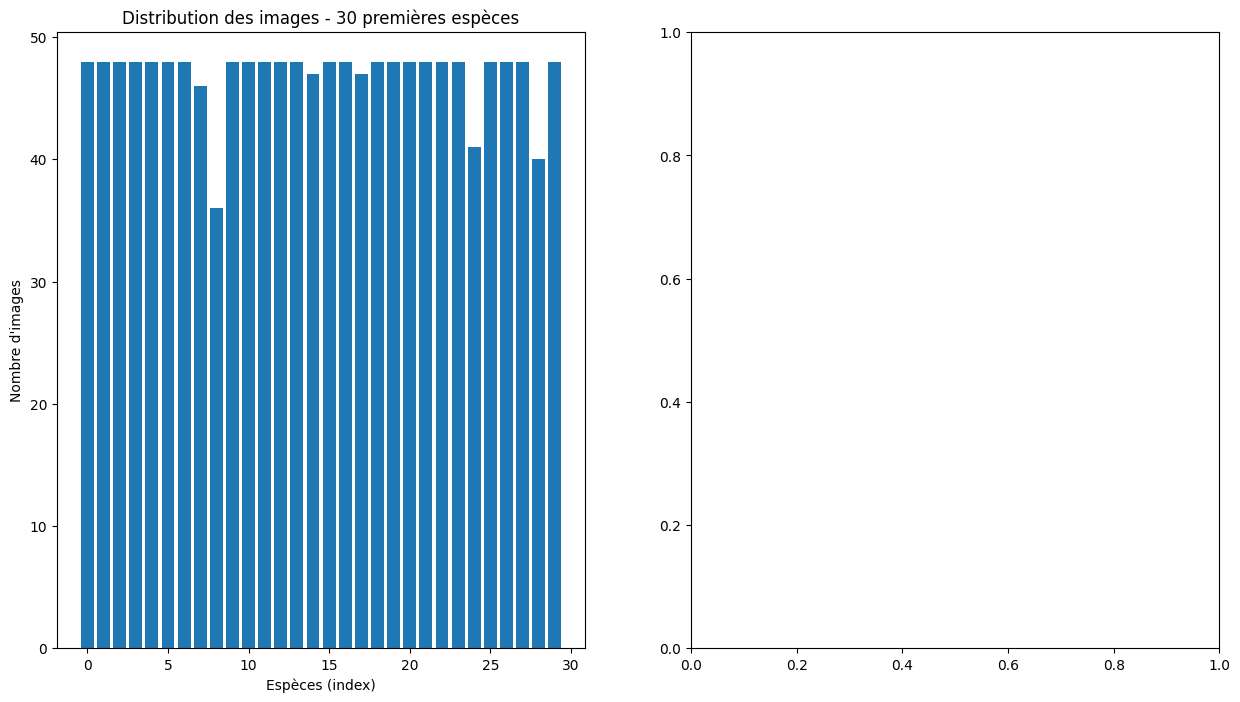

In [ ]:
# Visualisation de la distribution
species_data = train_species_data
plt.figure(figsize=(15, 8))
species_names = list(species_data.keys())[:30]  # Top 30 pour la lisibilité
species_counts = [species_data[name]['count'] for name in species_names]

plt.subplot(1, 2, 1)
plt.bar(range(len(species_names)), species_counts)
plt.title('Distribution des images - 30 premières espèces')
plt.xlabel('Espèces (index)')
plt.ylabel('Nombre d\'images')

plt.subplot(1, 2, 2)
plt.hist(counts, bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogramme de la distribution')
plt.xlabel('Nombre d\'images par espèce')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

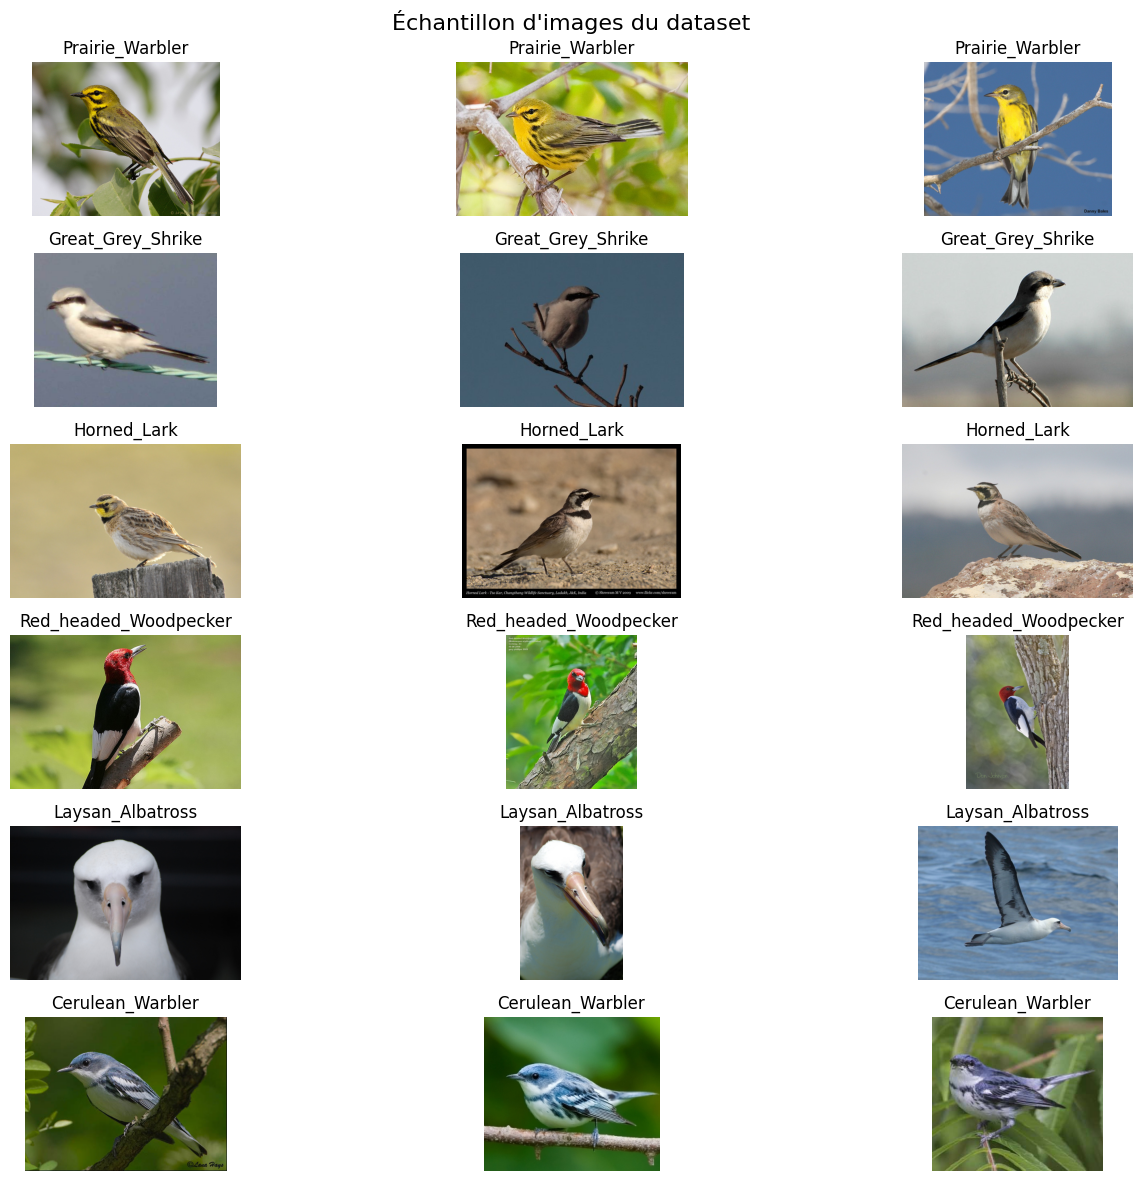

In [ ]:
# Échantillonnage d'images pour visualisation
def show_sample_images(species_data, n_species=6, n_images_per_species=3):
    """
    Affiche un échantillon d'images du dataset
    """
    species_list = list(species_data.keys())[:n_species]

    fig, axes = plt.subplots(n_species, n_images_per_species, figsize=(15, 12))

    for i, species in enumerate(species_list):
        sample_files = species_data[species]['sample_files'][:n_images_per_species]

        for j, img_path in enumerate(sample_files):
            try:
                img = Image.open(img_path).convert('RGB')
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{species}")
                axes[i, j].axis('off')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, 'Image non disponible',
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

    plt.suptitle('Échantillon d\'images du dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(species_data)

## 🐦 Création du Dataset Personnalisé

### **Objectif**
Cette section implémente une classe `BirdDataset` pour :
- **Charger efficacement** les images d'oiseaux et leurs labels
- **Préparer les données** pour l'entraînement avec PyTorch
- **Gérer automatiquement** le mapping des espèces vers des indices numériques

---




In [ ]:
#Création du Dataset Personnalisé

class BirdDataset(Dataset):
    """
    Dataset personnalisé pour la classification d'oiseaux
    Compatible avec NumPy et PyTorch natif
    """

    def __init__(self, data_path, transform=None, species_to_idx=None):
        """
        Args:
            data_path: Chemin vers le dossier du dataset
            transform: Transformations à appliquer aux images
            species_to_idx: Dictionnaire de mapping espèce -> index
        """
        self.data_path = data_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Création du mapping espèce -> index si non fourni
        if species_to_idx is None:
            species_list = sorted(os.listdir(data_path))
            self.species_to_idx = {species: idx for idx, species in enumerate(species_list)}
        else:
            self.species_to_idx = species_to_idx

        self.idx_to_species = {idx: species for species, idx in self.species_to_idx.items()}

        # Collecte de tous les chemins d'images et labels
        for species in os.listdir(data_path):
            species_path = os.path.join(data_path, species)
            if os.path.isdir(species_path) and species in self.species_to_idx:
                # Recherche de tous les fichiers image
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                    image_files = glob.glob(os.path.join(species_path, ext))
                    self.image_paths.extend(image_files)
                    self.labels.extend([self.species_to_idx[species]] * len(image_files))

        print(f"Dataset initialisé: {len(self.image_paths)} images, {len(self.species_to_idx)} classes")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Chargement de l'image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Application des transformations
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_distribution(self):
        """
        Retourne la distribution des classes sous forme de numpy array
        """
        unique, counts = np.unique(self.labels, return_counts=True)
        return unique, counts

    def get_species_name(self, idx):
        """
        Retourne le nom de l'espèce à partir de l'index
        """
        return self.idx_to_species.get(idx, "Unknown")

**Préparation des Données**

## Stratégie de Data Augmentation

### **Transformations pour l'Entraînement**
Ces transformations visent à **diversifier artificiellement** le dataset et **améliorer la généralisation** du modèle :

1. **Redimensionnement Initial**  
   `Resize(256)` → Standardise la taille de base avant crop

2. **Recadrage Aléatoire**  
   `RandomResizedCrop(224)` avec :
   - Taille finale : 224x224 pixels (taille standard pour les modèles CNN)
   - Zoom aléatoire : entre 80% et 100% de l'image originale  
   *→ Simule différentes distances d'observation*

3. **Flip Horizontal**  
   `RandomHorizontalFlip(p=0.5)`  
   *→ Reproduit les changements d'orientation naturels (50% de chance)*

4. **Rotation Aléatoire**  
   `RandomRotation(15)`  
   - Permet des inclinaisons jusqu'à ±15°  
   *→ Capture les angles de vue variés des oiseaux*

5. **Variations Colorimétriques**  
   `ColorJitter()` avec :
   - Luminosité (±20%)
   - Contraste (±20%)
   - Saturation (±20%)
   - Teinte (±10%)  
   *→ Compense les différences d'éclairage et de captation*

6. **Normalisation**  
   `Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)`  
   - Utilise les statistiques RGB d'ImageNet  
   *→ Essentiel pour le transfer learning*

### **Transformations pour la Validation**
Approche minimaliste pour une **évaluation fiable** :

1. **Redimensionnement**  
   `Resize(256)` → Même échelle qu'à l'entraînement

2. **Crop Central**  
   `CenterCrop(224)` → Extraction cohérente de la zone d'intérêt

3. **Normalisation Identique**  
   Mêmes paramètres `mean/std` que l'entraînement  
   *→ Garantit la consistance des données*






## 🔧 Préparation des Transformations d'Images

### **Objectif**
Configurer des pipelines de transformations pour :
- **Augmenter** les données d'entraînement (réduire le surapprentissage)
- **Normaliser** les images selon les statistiques ImageNet
- **Préparer** les formats compatibles PyTorch

---
### **1. Statistiques ImageNet**

* IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Moyennes RGB
* IMAGENET_STD = [0.229, 0.224, 0.225]   # Écarts-types RGB

Ces valeurs standard (calculées sur 1M+ d'images) aident à :

* Centrer les données autour de 0

* Uniformiser l'échelle des canaux RGB

* Améliorer la convergence du modèle

ℹ️ Utilisées par la plupart des modèles pré-entraînés

---
# **Transformations d'Entraînement**
**Opérations appliquées (dans l'ordre) :**

1. Redimensionnement → 256px (côté court)

2. RandomResizedCrop :

     * Recadrage aléatoire (224px)

     * Zoom aléatoire (80-100% de l'image)

3. Augmentations :

     * Flip horizontal (50% de chance)

     * Rotation (±15°)

     * Variations de couleur (luminosité/contrast/saturation/teinte)

     * Flou gaussien (20% de chance)

4. Conversion en Tensor PyTorch

5. Normalisation avec les stats ImageNet


In [ ]:
# Statistiques ImageNet pour la normalisation
IMAGENET_MEAN = [0.485, 0.456, 0.406] # Moyennes RGB
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformations pour l'entraînement (avec augmentation)
train_transforms = transforms.Compose([
    transforms.Resize(256),  # Redimensionnement initial
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop aléatoire
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal
    transforms.RandomRotation(degrees=15),  # Rotation aléatoire
    transforms.ColorJitter(
        brightness=0.2,  # Variation de luminosité
        contrast=0.2,    # Variation de contraste
        saturation=0.2,  # Variation de saturation
        hue=0.1         # Variation de teinte
    ),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.2),  # Flou gaussien occasionnel
    transforms.ToTensor(),  # Conversion en tensor
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # Normalisation
])

# Transformations pour la validation (sans augmentation)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Crop central
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Création des datasets
full_dataset = BirdDataset(train_path, transform=None)  # Dataset complet pour l'analyse


Dataset initialisé: 9414 images, 200 classes


# ***Division train/validation (80%/20%)***

In [ ]:

# Création des datasets directement depuis les dossiers train et test
train_dataset = BirdDataset(train_path, transform=train_transforms)
val_dataset = BirdDataset(test_path, transform=val_transforms,
                          species_to_idx=train_dataset.species_to_idx)

# Vérification que les datasets utilisent le même mapping d'espèces
print(f"Dataset d'entraînement: {len(train_dataset)} images")
print(f"Dataset de test: {len(val_dataset)} images")
print(f"Nombre de classes: {len(train_dataset.species_to_idx)}")

Dataset initialisé: 9414 images, 200 classes
Dataset initialisé: 2374 images, 200 classes
Dataset d'entraînement: 9414 images
Dataset de test: 2374 images
Nombre de classes: 200


**Création des DataLoaders**

In [ ]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True)

print(f"Batches d'entraînement: {len(train_loader)}")
print(f"Batches de validation: {len(val_loader)}")

Batches d'entraînement: 295
Batches de validation: 75


# **Architecture du Modèle - ResNet18**

resnet18_bird_classification.svg

## Architecture du Modèle : ResNet18 Personnalisé

### **1. Choix de ResNet18**
<img src="https://miro.medium.com/v2/resize:fit:1400/1*D0F3UitQ2l5Q0Ak-tjEdJg.png" width="300" align="right">

**Pourquoi ResNet18 ?**
- **Équilibre parfait** : Assez profond (18 couches) mais léger (11M paramètres)
- **Architecture éprouvée** : Performances solides en vision par ordinateur
- **Compatibilité** : Pré-entraînement disponible sur ImageNet

**Caractéristiques clés** :
- Basé sur des **blocs résiduels** (skip connections)
- Sortie originale : 1000 classes (ImageNet)
- Sortie modifiée : **200 classes** (vos espèces d'oiseaux)

---

ResNet18 Structure:
1. Couche d'entrée: Convolution 7x7, 64 filtres
2. 4 blocs résiduels avec [2,2,2,2] couches chacun
3. Global Average Pooling
4. Couche fully connected finale

Avantages:
- Skip connections évitent la dégradation du gradient
- Architecture prouvée sur ImageNet
- Bon compromis entre performance et vitesse


In [ ]:
class BirdClassifier(nn.Module):
    """
    Modèle de classification d'oiseaux basé sur ResNet18
    """

    def __init__(self, num_classes, pretrained=True):
        super(BirdClassifier, self).__init__()

        # Chargement de ResNet18 pré-entraîné
        self.backbone = models.resnet18(pretrained=pretrained)

        # Remplacement de la dernière couche fully connected
        # ResNet18 a 512 features en sortie avant la FC
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

        self.num_classes = num_classes

    def forward(self, x):
        return self.backbone(x)

    def freeze_backbone(self):
        """
        Gèle les couches du backbone pour le feature extraction
        """
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Dégèle seulement la dernière couche FC
        for param in self.backbone.fc.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """
        Dégèle toutes les couches pour le fine-tuning
        """
        for param in self.backbone.parameters():
            param.requires_grad = True

# Création du modèle
num_classes = len(full_dataset.species_to_idx)
model = BirdClassifier(num_classes=num_classes, pretrained=True)
model = model.to(device)

print("=== ARCHITECTURE DU MODÈLE ===")
print(f"Nombre de classes: {num_classes}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Paramètres totaux: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")

=== ARCHITECTURE DU MODÈLE ===
Nombre de classes: 200
Paramètres totaux: 11,279,112
Paramètres entraînables: 11,279,112


# **Fonctions d'Entraînement et d'Évaluation**

## Fonction `train_epoch` - Processus d'Entraînement

### **Objectif Principal**
Effectue un cycle complet d'entraînement (une "époque") sur l'ensemble des données d'entraînement.


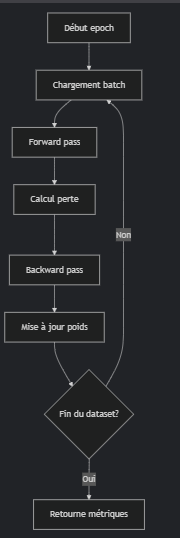

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Entraîne le modèle pour une époque
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Barre de progression
    pbar = tqdm(train_loader, desc="Training")

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistiques
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Mise à jour de la barre de progression
        if batch_idx % 10 == 0:
            current_acc = 100. * correct_predictions / total_samples
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct_predictions / total_samples

    return epoch_loss, epoch_acc

## Fonction de Validation du Modèle

### **Objectif Principal**
Évaluer les performances du modèle sur des données non vues (ensemble de validation) sans modifier les paramètres du modèle.


In [ ]:
def validate_model(model, val_loader, criterion, device):
    """
    Évalue le modèle sur le dataset de validation
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Stockage pour les métriques détaillées
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct_predictions / total_samples

    return epoch_loss, epoch_acc, np.array(all_predictions), np.array(all_labels)

In [ ]:
def calculate_top_k_accuracy(model, val_loader, device, k=5):
    """
    Calcule la top-k accuracy
    """
    model.eval()
    correct_top_k = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Top-k prédictions
            _, top_k_predicted = torch.topk(outputs, k, dim=1)

            # Vérification si le vrai label est dans les top-k
            correct_top_k += sum([label.item() in top_k_pred for label, top_k_pred in
                                 zip(labels, top_k_predicted.cpu().numpy())])
            total_samples += labels.size(0)

    top_k_acc = 100. * correct_top_k / total_samples
    return top_k_acc

# **Configuration de l'Entraînement**

In [ ]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()

# Optimiseur avec différents learning rates pour différentes parties
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler pour ajuster le learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Stockage de l'historique d'entraînement
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

## Entraînement du modèle en deux phases : Feature Extraction & Fine-Tuning

Ce code met en place un entraînement en deux étapes pour le modèle de deep learning, basé sur un backbone pré-entraîné comme ResNet18. L'objectif est de tirer parti des connaissances déjà apprises par le modèle tout en l'adaptant à une nouvelle tâche.

---

### Initialisation : fonction de perte, optimiseur et scheduler

```python
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

```


# ---**texte en gras**
Un dictionnaire history est utilisé pour stocker les métriques de performance (perte et précision) durant l’entraînement.


---
# **Phase 1 : Feature Extraction (extraction de caractéristiques)**

Backbone gelé : les couches pré-entraînées ne sont pas mises à jour. Seules les couches de classification sont entraînées.

* Objectif : entraîner rapidement la tête de classification avec peu de risque d'overfitting.

* Le modèle est entraîné pendant 5 époques.

Pendant chaque époque :

* Calcul des métriques d'entraînement et de validation.

* Mise à jour du scheduler.

* Sauvegarde du modèle si la performance de validation s’améliore.

---

# **Phase 2 : Fine-Tuning complet**

Toutes les couches sont dégelées, y compris le backbone.

Optimiseur différencié : chaque groupe de couches a un learning rate différent selon son niveau de profondeur :

* Couche de classification : 1e-3

* Dernière couche (layer4) : 1e-4

* Avant-dernière couche (layer3) : 5e-5

* Couches les plus profondes : 1e-5

Scheduler adapté : diminution du learning rate plus agressive (facteur 0.3).

Entraînement pendant 10 époques supplémentaires, avec la même logique que la phase 1 (évaluation + sauvegarde du meilleur modèle).

---
* Les meilleurs modèles de chaque phase sont sauvegardés dans :

    'best_model_phase1.pth'

    'best_model_final.pth'

* La meilleure précision de validation atteinte à la fin de chaque phase est affichée.



# **1. Feature Extraction (Couches Gelées)**

In [ ]:
print("=== PHASE 1: FEATURE EXTRACTION ===")
print("Entraînement avec couches backbone gelées")

# Gel du backbone
model.freeze_backbone()

# Vérification des paramètres entraînables
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Paramètres entraînables (phase 1): {trainable_params:,}")

# Entraînement phase 1
num_epochs_phase1 = 5
best_val_acc_phase1 = 0.0

for epoch in range(num_epochs_phase1):
    print(f"\nÉpoque {epoch+1}/{num_epochs_phase1}")

    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion, device)

    # Mise à jour du scheduler
    scheduler.step(val_loss)

    # Sauvegarde de l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc_phase1:
        best_val_acc_phase1 = val_acc
        torch.save(model.state_dict(), 'best_model_phase1.pth')
        print(f"Nouveau meilleur modèle sauvegardé! Acc: {val_acc:.2f}%")

print(f"Fin Phase 1 - Meilleure validation accuracy: {best_val_acc_phase1:.2f}%")

=== PHASE 1: FEATURE EXTRACTION ===
Entraînement avec couches backbone gelées
Paramètres entraînables (phase 1): 102,600

Époque 1/5


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.13it/s]


Train - Loss: 4.4301, Acc: 11.97%
Val   - Loss: 3.2721, Acc: 28.48%
Nouveau meilleur modèle sauvegardé! Acc: 28.48%

Époque 2/5


Validation: 100%|██████████| 75/75 [00:11<00:00,  6.49it/s]


Train - Loss: 3.0152, Acc: 33.15%
Val   - Loss: 2.5718, Acc: 38.80%
Nouveau meilleur modèle sauvegardé! Acc: 38.80%

Époque 3/5


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.15it/s]


Train - Loss: 2.4723, Acc: 42.54%
Val   - Loss: 2.2198, Acc: 47.05%
Nouveau meilleur modèle sauvegardé! Acc: 47.05%

Époque 4/5


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.14it/s]


Train - Loss: 2.1677, Acc: 48.29%
Val   - Loss: 2.0142, Acc: 48.99%
Nouveau meilleur modèle sauvegardé! Acc: 48.99%

Époque 5/5


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.16it/s]

Train - Loss: 1.9564, Acc: 52.14%
Val   - Loss: 1.9686, Acc: 49.41%
Nouveau meilleur modèle sauvegardé! Acc: 49.41%
Fin Phase 1 - Meilleure validation accuracy: 49.41%


# **2. Fine-tuning Complet**

In [ ]:
print("\n=== PHASE 2: FINE-TUNING COMPLET ===")
print("Dégel de toutes les couches pour fine-tuning")

# Dégel du backbone
model.unfreeze_backbone()

# Nouveau optimiseur avec learning rate plus faible
optimizer = optim.AdamW([
    {'params': model.backbone.fc.parameters(), 'lr': 1e-3},  # Tête de classification
    {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},  # Dernière couche ResNet
    {'params': model.backbone.layer3.parameters(), 'lr': 5e-5},  # Avant-dernière couche
    {'params': list(model.backbone.layer1.parameters()) +
               list(model.backbone.layer2.parameters()) +
               list(model.backbone.conv1.parameters()) +
               list(model.backbone.bn1.parameters()), 'lr': 1e-5}  # Couches basses
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2, verbose=True
)

# Entraînement phase 2
num_epochs_phase2 = 10
best_val_acc_phase2 = best_val_acc_phase1

for epoch in range(num_epochs_phase2):
    print(f"\nÉpoque {epoch+1}/{num_epochs_phase2} (Fine-tuning)")

    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc, _, _ = validate_model(model, val_loader, criterion, device)

    # Mise à jour du scheduler
    scheduler.step(val_loss)

    # Sauvegarde de l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc_phase2:
        best_val_acc_phase2 = val_acc
        torch.save(model.state_dict(), 'best_model_final.pth')
        print(f"Nouveau meilleur modèle sauvegardé! Acc: {val_acc:.2f}%")

print(f"Fin Fine-tuning - Meilleure validation accuracy: {best_val_acc_phase2:.2f}%")


=== PHASE 2: FINE-TUNING COMPLET ===
Dégel de toutes les couches pour fine-tuning

Époque 1/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.08it/s]


Train - Loss: 1.5057, Acc: 59.01%
Val   - Loss: 1.2706, Acc: 64.95%
Nouveau meilleur modèle sauvegardé! Acc: 64.95%

Époque 2/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.12it/s]


Train - Loss: 0.9815, Acc: 72.55%
Val   - Loss: 1.1898, Acc: 67.90%
Nouveau meilleur modèle sauvegardé! Acc: 67.90%

Époque 3/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.10it/s]


Train - Loss: 0.7541, Acc: 78.61%
Val   - Loss: 1.1491, Acc: 67.69%

Époque 4/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:11<00:00,  6.31it/s]


Train - Loss: 0.5828, Acc: 83.57%
Val   - Loss: 1.1480, Acc: 69.04%
Nouveau meilleur modèle sauvegardé! Acc: 69.04%

Époque 5/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.12it/s]


Train - Loss: 0.4669, Acc: 86.62%
Val   - Loss: 1.1699, Acc: 68.11%

Époque 6/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.20it/s]


Train - Loss: 0.3377, Acc: 90.32%
Val   - Loss: 1.1281, Acc: 70.05%
Nouveau meilleur modèle sauvegardé! Acc: 70.05%

Époque 7/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:11<00:00,  6.29it/s]


Train - Loss: 0.2800, Acc: 91.83%
Val   - Loss: 1.2681, Acc: 68.58%

Époque 8/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.20it/s]


Train - Loss: 0.2381, Acc: 93.38%
Val   - Loss: 1.1592, Acc: 70.72%
Nouveau meilleur modèle sauvegardé! Acc: 70.72%

Époque 9/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.16it/s]


Train - Loss: 0.1997, Acc: 94.23%
Val   - Loss: 1.2239, Acc: 69.46%

Époque 10/10 (Fine-tuning)


Validation: 100%|██████████| 75/75 [00:12<00:00,  6.24it/s]


Train - Loss: 0.1060, Acc: 97.72%
Val   - Loss: 1.0634, Acc: 73.42%
Nouveau meilleur modèle sauvegardé! Acc: 73.42%
Fin Fine-tuning - Meilleure validation accuracy: 73.42%


In [ ]:
# Installer les librairies nécessaires
!pip install pydub simpleaudio requests pillow torchvision
!apt-get install ffmpeg  # pour la conversion mp3 -> wav


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-linux_x86_64.whl size=2054419 sha256=14f5bca6b84274d584f6697eca9446249d5025a119d99be8f1385857f42d514e
  Stored in directory: /root/.cache/pip/wheels/44/74/11/9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!ls



best_model_final.pth
best_model_phase1.pth
bird_classifier_20250615_153544_complete.zip
bird_classifier_20250615_153707_complete.zip
bird_classifier_model
sample_data


Chargement d’un modèle entraîné pour la classification d’oiseaux


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
import os
import tempfile
from pydub import AudioSegment
import simpleaudio as sa
from tqdm import tqdm

# recharger ta classe BirdClassifier
class BirdClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(BirdClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        return self.backbone(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 200

# Charger le modèle sauvegardé
model = BirdClassifier(num_classes=num_classes, pretrained=False)
model.load_state_dict(torch.load('best_model_final.pth', map_location=device))
model.to(device)
model.eval()

print("✅ Modèle chargé avec succès")


✅ Modèle chargé avec succès


In [ ]:
# Les mêmes transformations que pendant l'entraînement
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## 🐦🔊 Prédiction d'espèce d’oiseau et lecture de son

Dans cette partie du notebook, on utilise une image d'oiseau pour :
1. **Prédire son espèce** à l’aide du modèle entraîné,
2. **Afficher l’image avec la prédiction**,
3. **Rechercher et lire un enregistrement audio** de cet oiseau depuis la base de données en ligne [Xeno-Canto](https://xeno-canto.org).

---




In [ ]:
import matplotlib.pyplot as plt


class_names = []

def predict_bird(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    class_name = class_names[predicted.item()]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_name}")
    plt.show()

    return class_name


1. Envoie une requête HTTP à l’API de Xeno-Canto pour rechercher un enregistrement audio d’un oiseau à partir de son nom.

2. Télécharge le premier enregistrement audio disponible.

3. Convertit l’audio de .mp3 vers .wav.

4. Joue l’audio dans le notebook

In [ ]:
import IPython.display as ipd
def search_xeno_canto_and_play(bird_name):
    print(f"\n🔍 Searching Xeno-Canto for: {bird_name}")
    query = bird_name.replace("_", " ")  # si tes noms de classes ont des underscores
    url = f"https://xeno-canto.org/api/2/recordings?query={query}"
    response = requests.get(url)
    data = response.json()

    if data['numRecordings'] == '0':
        print("❌ No recordings found for", query)
        return

    recording = data['recordings'][0]
    file_part = recording['file']
    if file_part.startswith("https://"):
       file_url = file_part
    else:
       file_url = f"https:{file_part}"

    print(f"✅ Found recording: {file_url}")


    # Téléchargement du fichier audio
    with tempfile.TemporaryDirectory() as tmpdirname:
       mp3_path = os.path.join(tmpdirname, "bird.mp3")
       wav_path = os.path.join(tmpdirname, "bird.wav")

       with open(mp3_path, "wb") as f:
           f.write(requests.get(file_url).content)

       audio = AudioSegment.from_mp3(mp3_path)
       audio.export(wav_path, format="wav")

       # Lecture du fichier audio dans Colab
       display(ipd.Audio(wav_path))


In [ ]:
def predict_and_play(image_path):
    bird_name = predict_bird(image_path)
    search_xeno_canto_and_play(bird_name)


Saving Capture d’écran 2025-06-15 172959.png to Capture d’écran 2025-06-15 172959.png


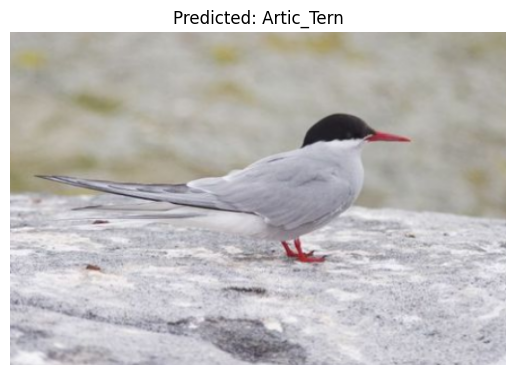


🔍 Searching Xeno-Canto for: Artic_Tern
❌ No recordings found for Artic Tern


In [ ]:
# Charger une image depuis le pc
from google.colab import files

uploaded = files.upload()

# Suppose qu’une seule image est uploadée
image_path = list(uploaded.keys())[0]

# Prédire et écouter
predict_and_play(image_path)


In [ ]:
# Voir les 5 premières classes pour vérifier que ça a bien fonctionné
print(os.listdir(test_path)[:5])

# Récupérer les noms de classes depuis le dossier Test (par ordre alphabétique)
class_names = sorted(os.listdir(test_path))
num_classes = len(class_names)
print("Nombre de classes:", num_classes)



['White_crowned_Sparrow', 'White_eyed_Vireo', 'Laysan_Albatross', 'Horned_Lark', 'Eared_Grebe']
Nombre de classes: 200


In [ ]:
from PIL import Image
from tqdm import tqdm

correct = 0
total = 0
errors = []

for class_name in tqdm(class_names):
    class_path = os.path.join(test_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)

        predicted_class = class_names[predicted.item()]

        if predicted_class == class_name:
            correct += 1
        else:
            errors.append((img_path, class_name, predicted_class))

        total += 1

accuracy = 100 * correct / total
print(f"\n✅ Accuracy sur le dossier Test : {accuracy:.2f}%")
print(f"Nombre total d'images testées : {total}")
print(f"Nombre d'erreurs : {len(errors)}")


100%|██████████| 200/200 [00:21<00:00,  9.20it/s]


✅ Accuracy sur le dossier Test : 70.39%
Nombre total d'images testées : 2374
Nombre d'erreurs : 703


In [ ]:
from PIL import Image
from tqdm import tqdm

correct = 0
total = 0
errors = []

for class_name in tqdm(class_names):
    class_path = os.path.join(test_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)

        predicted_class = class_names[predicted.item()]

        if predicted_class == class_name:
            correct += 1
        else:
            errors.append((img_path, class_name, predicted_class))

        total += 1

accuracy = 100 * correct / total
print(f"\n✅ Accuracy sur le dossier Test : {accuracy:.2f}%")
print(f"Nombre total d'images testées : {total}")
print(f"Nombre d'erreurs : {len(errors)}")

100%|██████████| 200/200 [00:22<00:00,  8.80it/s]


✅ Accuracy sur le dossier Test : 70.39%
Nombre total d'images testées : 2374
Nombre d'erreurs : 703


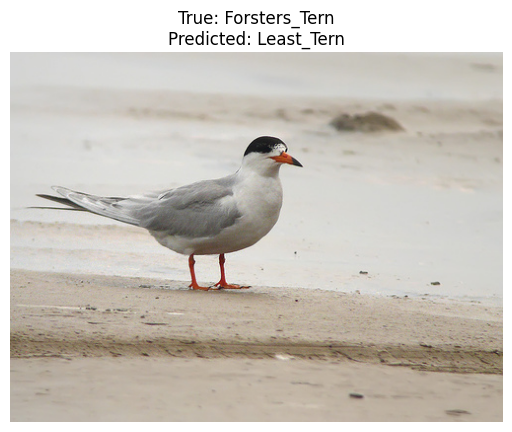

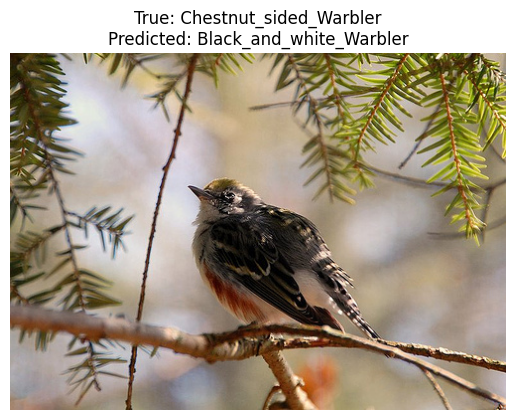

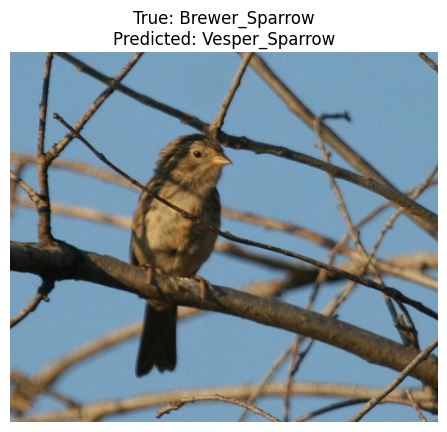

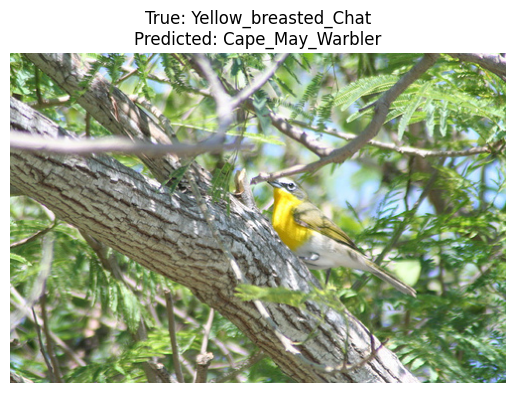

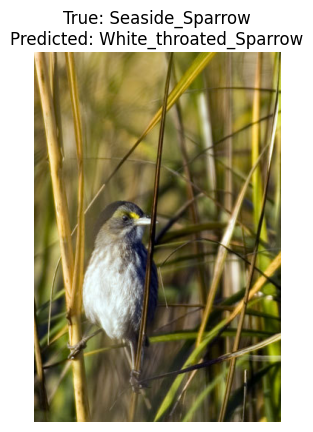

In [ ]:
import random
import matplotlib.pyplot as plt

# Afficher 5 exemples d’erreurs
for i in range(5):
    if i >= len(errors):
        break

    img_path, true_class, pred_class = random.choice(errors)
    img = Image.open(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_class}\nPredicted: {pred_class}")
    plt.show()


# **Évaluation Finale du Modèle**

In [ ]:
# Chargement du meilleur modèle
model.load_state_dict(torch.load('best_model_final.pth'))

# Évaluation finale
print("\n=== ÉVALUATION FINALE ===")
final_val_loss, final_val_acc, y_pred, y_true = validate_model(model, val_loader, criterion, device)
top5_acc = calculate_top_k_accuracy(model, val_loader, device, k=5)

print(f"Accuracy finale: {final_val_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

# Métriques détaillées avec sklearn
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Précision moyenne (pondérée): {precision:.4f}")
print(f"Rappel moyen (pondéré): {recall:.4f}")
print(f"F1-Score moyen (pondéré): {f1:.4f}")


=== ÉVALUATION FINALE ===


Validation: 100%|██████████| 75/75 [00:12<00:00,  5.94it/s]


Accuracy finale: 73.42%
Top-5 Accuracy: 92.33%
Précision moyenne (pondérée): 0.7511
Rappel moyen (pondéré): 0.7342
F1-Score moyen (pondéré): 0.7310


# **Visualisation des Résultats**

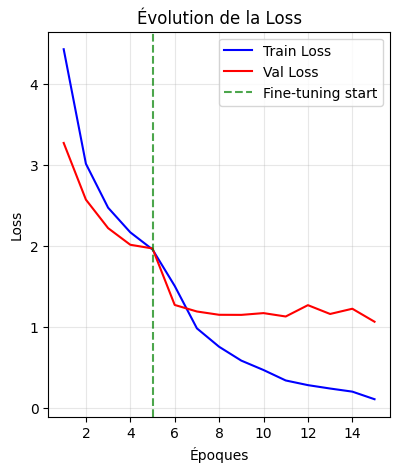

In [ ]:
# Courbes d'apprentissage
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
epochs = range(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
plt.axvline(x=num_epochs_phase1, color='g', linestyle='--', alpha=0.7, label='Fine-tuning start')
plt.title('Évolution de la Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

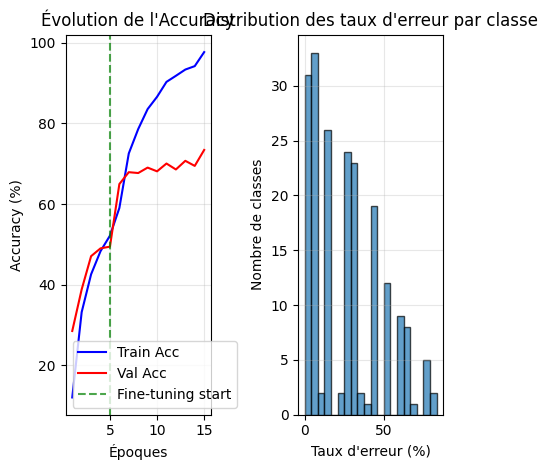

In [ ]:
# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
plt.axvline(x=num_epochs_phase1, color='g', linestyle='--', alpha=0.7, label='Fine-tuning start')
plt.title('Évolution de l\'Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution des erreurs par classe
plt.subplot(1, 3, 3)
unique_classes, class_counts = np.unique(y_true, return_counts=True)
class_errors = []
for class_id in unique_classes:
    mask = y_true == class_id
    class_predictions = y_pred[mask]
    errors = np.sum(class_predictions != class_id)
    error_rate = errors / np.sum(mask) * 100
    class_errors.append(error_rate)

plt.hist(class_errors, bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution des taux d\'erreur par classe')
plt.xlabel('Taux d\'erreur (%)')
plt.ylabel('Nombre de classes')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

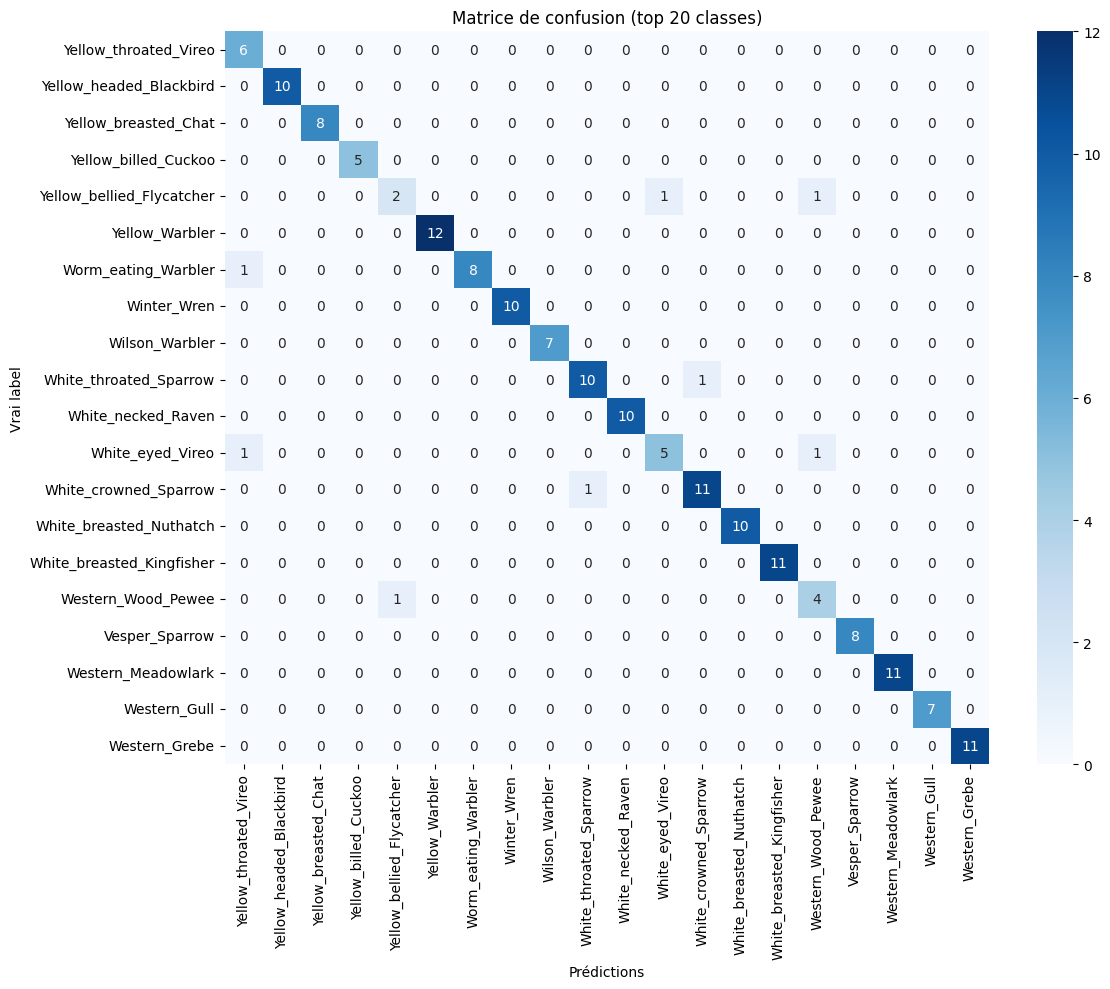

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix_sample(y_true, y_pred, class_names, n_classes=20):
    """
    Affiche une matrice de confusion pour un échantillon des classes les plus fréquentes.

    - y_true : array des vrais labels (indices numériques)
    - y_pred : array des prédictions (indices numériques)
    - class_names : liste de noms des classes (indexée sur les labels)
    - n_classes : nombre de classes à afficher (parmi les plus fréquentes)
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Sélection des classes les plus fréquentes (en fonction des y_true)
    unique_classes, counts = np.unique(y_true, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]  # tri décroissant
    top_classes_idx = unique_classes[sorted_indices[:n_classes]]

    # Filtrage des données pour ne garder que les paires où true label est dans top_classes
    mask = np.isin(y_true, top_classes_idx)
    y_true_sample = y_true[mask]
    y_pred_sample = y_pred[mask]

    # On filtre aussi les prédictions hors top_classes (pour éviter le KeyError)
    valid_mask = np.isin(y_pred_sample, top_classes_idx)
    y_true_sample = y_true_sample[valid_mask]
    y_pred_sample = y_pred_sample[valid_mask]

    # Création du mapping des classes
    class_mapping = {old_label: i for i, old_label in enumerate(top_classes_idx)}

    # Remapping des labels en indices 0..N
    y_true_mapped = np.array([class_mapping[label] for label in y_true_sample])
    y_pred_mapped = np.array([class_mapping[label] for label in y_pred_sample])

    # Récupération des noms des classes sélectionnées
    selected_class_names = [class_names[i] for i in top_classes_idx]

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true_mapped, y_pred_mapped)

    # Affichage
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names, yticklabels=selected_class_names)
    plt.xlabel('Prédictions')
    plt.ylabel('Vrai label')
    plt.title(f"Matrice de confusion (top {n_classes} classes)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_confusion_matrix_sample(y_true, y_pred, class_names, n_classes=20)
